In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

In [25]:
# Load and preprocess the dataset
df = pd.read_csv('data_recom.csv')
df = df[["prompt", "shortdesc"]]

In [26]:
# Create a combined text column
df['combined_text'] = df['prompt'] + ' ' + df['shortdesc']

In [27]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['combined_text'])

In [36]:
# Convert the TF-IDF matrix to a SparseTensor
tfidf_sparse = tf.sparse.reorder(tf.sparse.from_spmatrix(tfidf_matrix))

AttributeError: module 'tensorflow._api.v2.sparse' has no attribute 'from_spmatrix'

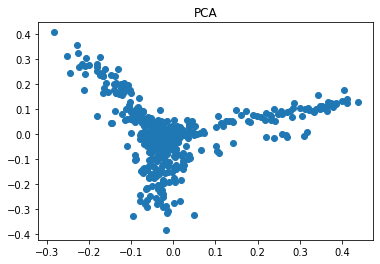

In [28]:
# Create PCA model for dimensionality reduction
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(tfidf_matrix.toarray())

# Plot the PCA results
plt.title("PCA")
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])
plt.show()

In [29]:
# Train a Nearest Neighbors model on the TF-IDF matrix
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(tfidf_matrix)

NearestNeighbors(metric='cosine')

In [30]:
# Function to recommend based on text input
def recommend(text):
    # Transform the input text using the TF-IDF vectorizer
    input_vector = vectorizer.transform([text])

    # Perform PCA on the input vector
    input_emb_2d = pca.transform(input_vector.toarray())

    # Find nearest neighbors based on cosine similarity
    neighbors = nn.kneighbors(input_vector, return_distance=False)[0]

    # Return recommended prompts
    return df['prompt'].iloc[neighbors].tolist()

In [32]:
# Define and train a simple neural network model
model = Sequential()
model.add(Embedding(input_dim=tfidf_matrix.shape[1], output_dim=32, input_length=tfidf_matrix.shape[1]))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(df['prompt'].unique()), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [33]:
# Train the model
model.fit(tfidf_matrix, np.arange(len(df['prompt'])), epochs=10)

InvalidArgumentError: {{function_node __wrapped__SerializeManySparse_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[1] = [0,211] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse] name: 

In [ ]:
# Neural Network Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=embeddings.shape[1], output_dim=50, input_length=embeddings.shape[1]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2, activation='linear')  # 2 output nodes for PCA
])

model.compile(optimizer='adam', loss='mse')  # Using mean squared error as loss for regression

In [ ]:
# Save the model
model.save("recommendation_model.h5")

In [ ]:
# Test the recommendation function
text_input = "cara belajar yang efektif"
recommendations = recommend(text_input)
print("Recommended prompts:", recommendations)